# Рекуррентные нейронных сетей

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("C:/Users/Zhastay/Downloads/jena_climate_2009_2016/data.csv")
df.head()

,Unnamed: 0,id,temp,gas,humid
0,1,1,25,98,37
1,2,2,25,108,35
2,3,3,25,100,34
3,4,4,25,97,33
4,5,5,25,94,33


In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
uni_data = df['temp']
uni_data.index = df['id']
uni_data.head()

id
1    25
2    25
3    25
4    25
5    25
Name: temp, dtype: int64

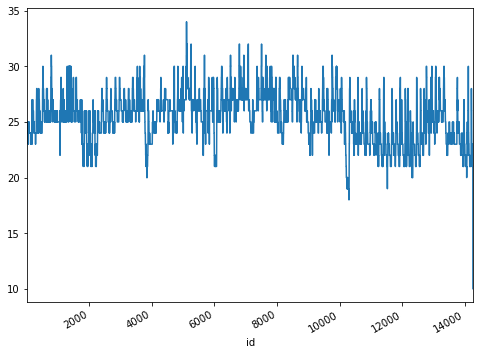

In [6]:
TRAIN_SPLIT = 11000
tf.random.set_seed(13)
uni_data = df['temp']
uni_data.index = df['id']
uni_data.head()
uni_data.plot(subplots=True)
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [50]:
univariate_past_history = 100
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-1.50532164]
 [-1.50532164]
 [-1.50532164]
 [-1.50532164]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.44503234]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.97517699]
 [-0.44503

In [84]:
print (len(x_train_uni))

10900


<module 'matplotlib.pyplot' from 'c:\\users\\zhastay\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

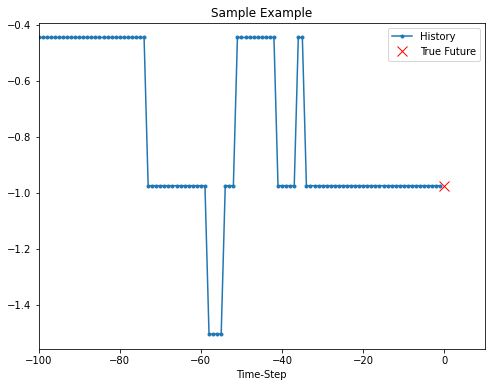

In [51]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'c:\\users\\zhastay\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

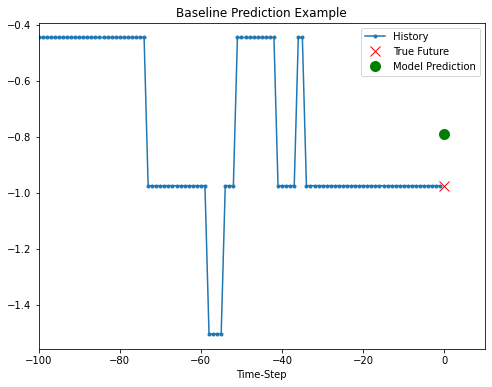

In [52]:
def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

# LSTM-модель для прогнозирование

In [53]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [54]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [55]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [56]:
print(x_train_uni.shape)

(10900, 100, 1)


In [57]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 40ms/step - loss: 0.4871 - val_loss: 0.5590
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2151 - val_loss: 0.2473
Epoch 3/10
200/200 [==============================] - 7s 34ms/step - loss: 0.1515 - val_loss: 0.1984
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 0.1322 - val_loss: 0.1761
Epoch 5/10
200/200 [==============================] - 8s 39ms/step - loss: 0.1202 - val_loss: 0.1630
Epoch 6/10
200/200 [==============================] - 7s 35ms/step - loss: 0.1132 - val_loss: 0.1592
Epoch 7/10
200/200 [==============================] - 7s 34ms/step - loss: 0.1103 - val_loss: 0.1580
Epoch 8/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1096 - val_loss: 0.1548
Epoch 9/10
200/200 [==============================] - 7s 33ms/step - loss: 0.1088 - val_loss: 0.1521
Epoch 10/10
200/200 [===========================

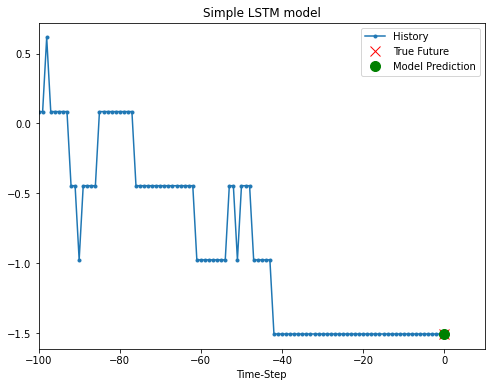

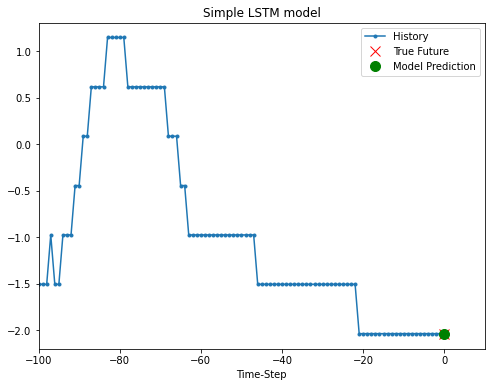

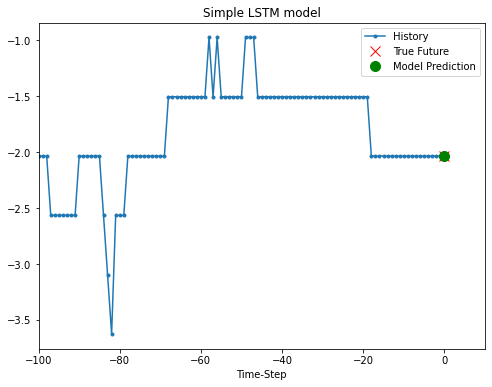

In [58]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# Прогнозирование на основе многомерного временного ряда

In [59]:
features_considered = ['temp', 'gas', 'humid']

In [60]:
features = df[features_considered]
features.index = df['id']
features.head()

,temp,gas,humid
id,,,
1,25,98,37
2,25,108,35
3,25,100,34
4,25,97,33
5,25,94,33


c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C223F5FE10>,
      dtype=object)

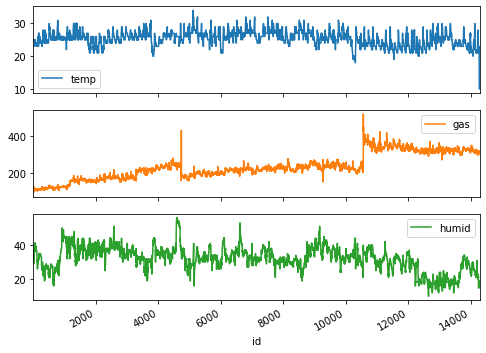

In [61]:
features.plot(subplots=True)

In [62]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [63]:
dataset = (dataset-data_mean)/data_std

Точечное прогнозирование

In [64]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Настроить надо правильно! Step шаги переход, например если каждые 10 минут шаг 6 = каждые 60 минут

In [65]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [66]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [67]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [68]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [69]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [70]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2685 - val_loss: 0.7774
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2013 - val_loss: 0.7337
Epoch 3/10
200/200 [==============================] - 21s 103ms/step - loss: 0.1584 - val_loss: 0.8917
Epoch 4/10
200/200 [==============================] - 21s 104ms/step - loss: 0.1411 - val_loss: 1.0213
Epoch 5/10
200/200 [==============================] - 21s 106ms/step - loss: 0.1341 - val_loss: 1.0579
Epoch 6/10
200/200 [==============================] - 20s 101ms/step - loss: 0.1281 - val_loss: 1.0254
Epoch 7/10
200/200 [==============================] - 20s 100ms/step - loss: 0.1242 - val_loss: 0.8537
Epoch 8/10
200/200 [==============================] - 20s 101ms/step - loss: 0.1190 - val_loss: 0.8862 loss: 0 - ETA: 0s - loss: 0.119
Epoch 9/10
200/200 [==============================] - 20s 101ms/step - loss: 0.1148 - val_loss: 0.883

In [71]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

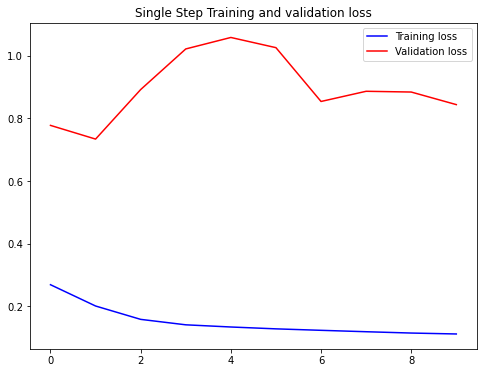

In [72]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

Выполнение точечного прогноза

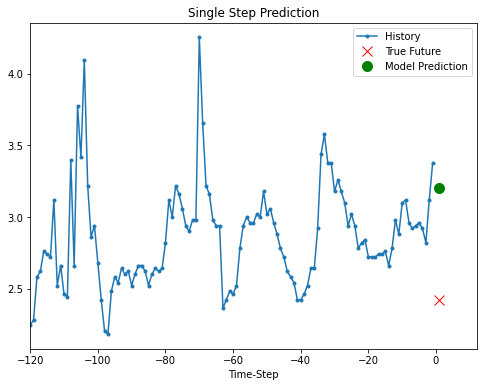

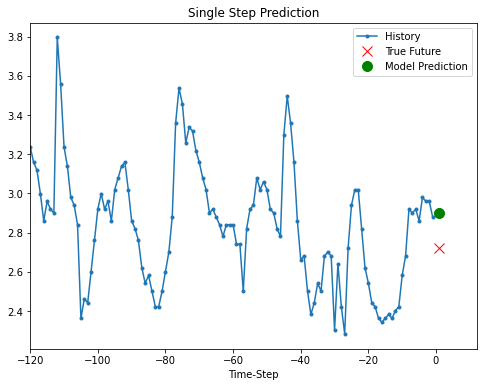

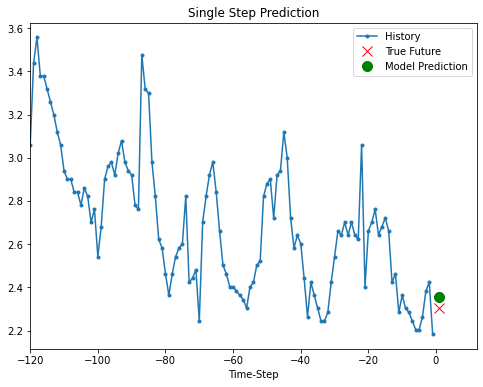

In [73]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

Интервальное прогнозирование

In [74]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [75]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [76]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [77]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

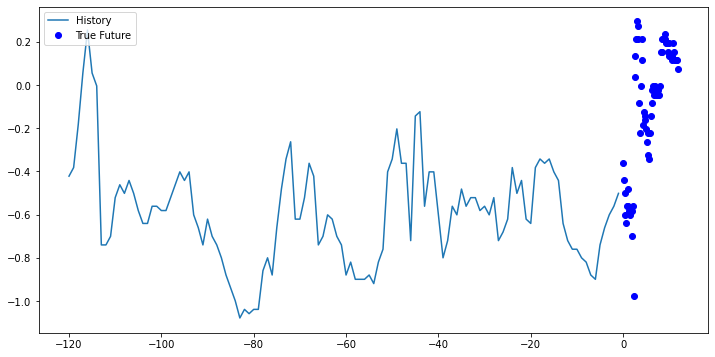

In [78]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [79]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [80]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [81]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 40s 198ms/step - loss: 0.4142 - val_loss: 0.3984
Epoch 2/10
200/200 [==============================] - 39s 196ms/step - loss: 0.2051 - val_loss: 1.0842
Epoch 3/10
200/200 [==============================] - 38s 189ms/step - loss: 0.1818 - val_loss: 1.0001
Epoch 4/10
200/200 [==============================] - 38s 188ms/step - loss: 0.1718 - val_loss: 1.0340
Epoch 5/10
200/200 [==============================] - 38s 189ms/step - loss: 0.1605 - val_loss: 1.2346
Epoch 6/10
200/200 [==============================] - 38s 188ms/step - loss: 0.1504 - val_loss: 1.2447
Epoch 7/10
200/200 [==============================] - 39s 193ms/step - loss: 0.1426 - val_loss: 1.2079
Epoch 8/10
200/200 [==============================] - 39s 195ms/step - loss: 0.1367 - val_loss: 1.1855
Epoch 9/10
200/200 [==============================] - 38s 191ms/step - loss: 0.1317 - val_loss: 1.1558
Epoch 10/10
200/200 [=========

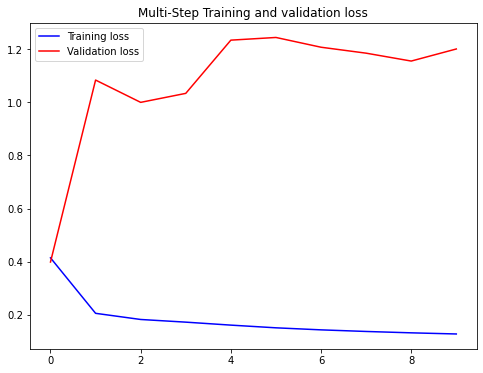

In [82]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Выполнение интервального прогноза

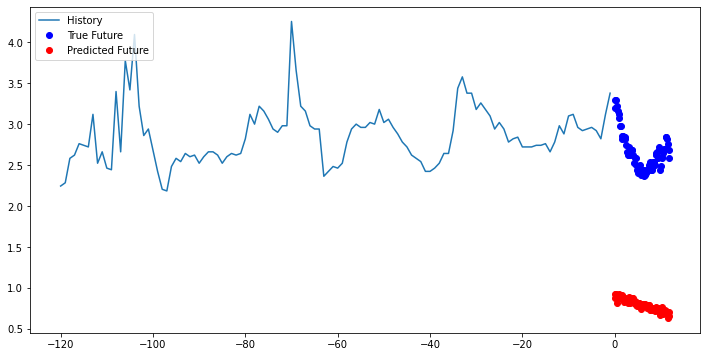

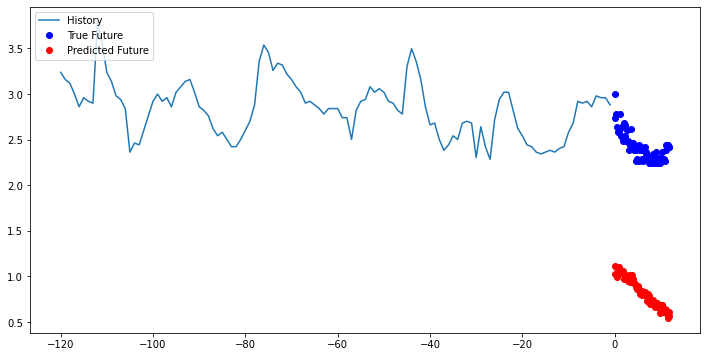

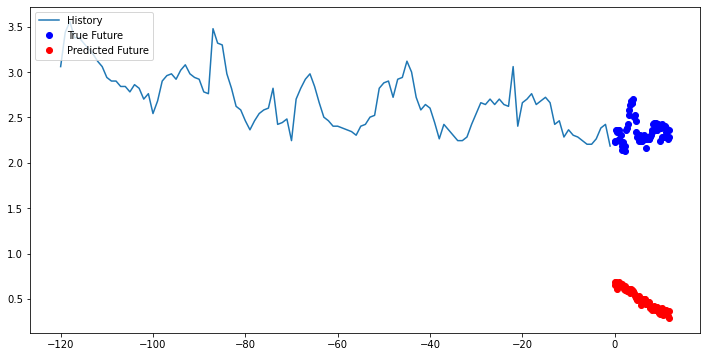

In [83]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])